# Imports

In [1]:
import os, gc, time, json, warnings
from pathlib import Path
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import io
from scipy.signal import resample_poly
from math import gcd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    roc_curve,
)

try:
    from thop import profile as thop_profile
    HAS_THOP = True
except ImportError:
    HAS_THOP = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Configuration

In [2]:
def _find_kaggle_input() -> Path:
    base = Path('/kaggle/input')
    if not base.exists():
        return Path('/kaggle/input/ninapro-db7/Dataset')

    def _has_subjects(p):
        return p.is_dir() and any(
            c.is_dir() and c.name.lower().startswith('subject_')
            for c in p.iterdir()
        )

    def _search(root, depth=0):
        if depth > 5:
            return None
        if _has_subjects(root):
            return root
        try:
            for child in sorted(root.iterdir()):
                if child.is_dir():
                    r = _search(child, depth + 1)
                    if r is not None:
                        return r
        except PermissionError:
            pass
        return None

    r = _search(base)
    return r if r else Path('/kaggle/input/ninapro-db7/Dataset')

In [3]:
class Config:
    # Paths 
    KAGGLE_INPUT   = _find_kaggle_input()
    KAGGLE_WORKING = Path('/kaggle/working')
    CKPT_DIR       = KAGGLE_WORKING / 'ckpts_exB'      
    DATA_CACHE_DIR = KAGGLE_WORKING / 'cache_exB'      
    PLOT_DIR       = KAGGLE_WORKING / 'plots_exB'
    RESULTS_DIR    = KAGGLE_WORKING / 'results_exB'

    # Dataset
    SUBJECTS       = list(range(1, 23))
    EMG_FS         = 2000          
    ACC_FS         = 148           
    TARGET_FS      = 2000          

    EMG_KEY        = 'emg'
    ACC_KEY        = 'acc'
    LBL_KEY        = 'restimulus'  # fallback: 'stimulus'
    GESTURE_MIN    = 13            # Exercise B gesture range (inclusive)
    GESTURE_MAX    = 29

    # Windowing
    WIN_MS         = 200           # window length in milliseconds
    STEP_MS        = 100           # step / hop in milliseconds  (50 % overlap)
    WIN_SAMPLES    = int(WIN_MS  * TARGET_FS / 1000)   # 400
    STEP_SAMPLES   = int(STEP_MS * TARGET_FS / 1000)   # 200

    # Splits─
    #  (train_frac, test_frac)  –  val is carved from train (10 %)
    SPLIT_RATIOS = [
        (0.70, 0.30),
        (0.60, 0.40), (0.50, 0.50), 
    ]
    VAL_FRAC_OF_TRAIN = 0.10

    # Training
    MIN_EPOCHS     = 100
    MAX_EPOCHS     = 200
    PATIENCE       = 20            # early-stop patience (plateau detection)
    BATCH_SIZE     = 256
    LR             = 1e-3
    WEIGHT_DECAY   = 1e-4
    NUM_WORKERS    = 2

    # Reproducibility
    SEED           = 42

    #  Compute
    DEVICE         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import random
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
if Config.DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(Config.SEED)

for d in [Config.CKPT_DIR, Config.DATA_CACHE_DIR,
          Config.PLOT_DIR, Config.RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Device  : {Config.DEVICE}")
print(f"Win     : {Config.WIN_SAMPLES} samples ({Config.WIN_MS} ms)")
print(f"Step    : {Config.STEP_SAMPLES} samples ({Config.STEP_MS} ms)")
print(f"Gestures: {Config.GESTURE_MIN}–{Config.GESTURE_MAX} "
      f"({Config.GESTURE_MAX - Config.GESTURE_MIN + 1} classes)")

Device  : cuda
Win     : 400 samples (200 ms)
Step    : 200 samples (100 ms)
Gestures: 13–29 (17 classes)


# DATA LOADING  (EMG + ACC + labels)

In [5]:
class EMGAccPreprocessor:
    """
    Loads EMG, ACC, and labels from a single .mat file.
    ACC is upsampled to EMG rate if its length differs.
    Only rows with gesture labels in [GESTURE_MIN, GESTURE_MAX] are kept.
    """

    def _find_key(self, data, candidates):
        for c in candidates:
            for k in data:
                if k.lower() == c.lower():
                    return k
        return None

    def apply(self, mat_path: Path):
        data = io.loadmat(str(mat_path))

        emg_key = self._find_key(data, [Config.EMG_KEY])
        acc_key = self._find_key(data, [Config.ACC_KEY, 'glove'])
        lbl_key = self._find_key(
            data, [Config.LBL_KEY, 'stimulus', 'label', 'labels'])

        if emg_key is None:
            raise KeyError(f"No EMG key in {mat_path.name}. "
                           f"Keys: {[k for k in data if not k.startswith('_')]}")
        if lbl_key is None:
            raise KeyError(f"No label key in {mat_path.name}.")
        emg    = data[emg_key].astype(np.float32)
        labels = data[lbl_key].flatten().astype(np.int32)

        # ACC: load if available, else zeros
        if acc_key is not None:
            acc = data[acc_key].astype(np.float32)
            # Upsample ACC to match EMG length if rates differ
            if len(acc) != len(emg):
                factor = len(emg) / len(acc)
                up   = round(factor * Config.ACC_FS)
                down = Config.ACC_FS
                g    = gcd(up, down)
                acc  = resample_poly(acc, up // g, down // g, axis=0).astype(np.float32)
            # Trim/pad to exact EMG length
            if len(acc) > len(emg):
                acc = acc[:len(emg)]
            elif len(acc) < len(emg):
                pad = np.zeros((len(emg) - len(acc), acc.shape[1]), dtype=np.float32)
                acc = np.vstack([acc, pad])
        else:
            acc = np.zeros((len(emg), 0), dtype=np.float32)

        n = min(len(emg), len(labels))
        emg, acc, labels = emg[:n], acc[:n], labels[:n]

        # Keep only Exercise B gestures
        mask   = (labels >= Config.GESTURE_MIN) & (labels <= Config.GESTURE_MAX)
        emg    = emg[mask]
        acc    = acc[mask]
        labels = labels[mask]

        return emg, acc, labels

# Subject Loader

In [6]:
class SubjectLoader:
    """
    Iterates over subjects, loads + checkpoints per-subject data,
    then builds a windowed dataset across all subjects.
    """

    def __init__(self):
        self.preprocessor = EMGAccPreprocessor()
        self.cache_dir    = Config.DATA_CACHE_DIR
    def _ckpt_path(self, sid: int) -> Path:
        return self.cache_dir / f'subj_{sid:02d}_exB.npz'

    def _find_subject_dir(self, sid: int) -> Path:
        candidates = [
            Config.KAGGLE_INPUT / f'Subject_{sid}',
            Config.KAGGLE_INPUT / f'subject_{sid}',
            Config.KAGGLE_INPUT / f'S{sid}',
            Config.KAGGLE_INPUT / f's{sid}',
        ]
        for p in candidates:
            if p.is_dir():
                return p
        for p in sorted(Config.KAGGLE_INPUT.iterdir()):
            if p.is_dir() and p.name.lower().endswith(str(sid)):
                return p
        raise FileNotFoundError(
            f"Cannot locate folder for subject {sid} under {Config.KAGGLE_INPUT}.")

    def _load_subject(self, sid: int):
        """Load and concatenate all .mat files for a subject; filter E2."""
        subj_dir  = self._find_subject_dir(sid)
        mat_files = sorted(subj_dir.glob('*.mat'))
        if not mat_files:
            mat_files = sorted(subj_dir.rglob('*.mat'))

        emg_parts, acc_parts, lbl_parts = [], [], []
        for mat_file in mat_files:
            try:
                emg, acc, lbl = self.preprocessor.apply(mat_file)
                if len(emg) > 0:
                    emg_parts.append(emg)
                    acc_parts.append(acc)
                    lbl_parts.append(lbl)
            except Exception as e:
                print(f"    Skip {mat_file.name}: {e}")

        if not emg_parts:
            raise RuntimeError(f"No valid data for subject {sid}")

        emg_all = np.vstack(emg_parts)
        acc_all = np.vstack(acc_parts) if all(
            a.shape[1] > 0 for a in acc_parts) else np.zeros(
            (sum(len(e) for e in emg_parts), 0), dtype=np.float32)
        lbl_all = np.concatenate(lbl_parts)
        return emg_all, acc_all, lbl_all

    #  Public API 
    def process_all(self, subjects=None):
        subjects = subjects or Config.SUBJECTS
        available = []
        n_acc_ch  = None

        for sid in tqdm(subjects, desc='Loading subjects'):
            ckpt = self._ckpt_path(sid)
            if ckpt.exists():
                data = np.load(ckpt, allow_pickle=True)
                n_acc_ch = int(data['n_acc_ch'])
                available.append(sid)
                print(f"  Subject {sid:02d}: checkpoint found  "
                      f"({data['n_rows']} rows, {n_acc_ch} ACC ch)")
                continue
            try:
                emg, acc, lbl = self._load_subject(sid)
                n_acc_ch = acc.shape[1]
                np.savez_compressed(
                    ckpt,
                    emg=emg, acc=acc, labels=lbl,
                    n_acc_ch=np.array(n_acc_ch),
                    n_rows=np.array(len(emg)),
                )
                available.append(sid)
                print(f"  Subject {sid:02d}: saved {len(emg):,} rows | "
                      f"EMG {emg.shape[1]} ch | ACC {n_acc_ch} ch")
                del emg, acc, lbl
                gc.collect()
            except Exception as exc:
                print(f"  Subject {sid:02d}: FAILED — {exc}")

        return available, (n_acc_ch or 0)

    def build_windows(self, subjects, n_acc_ch):
        """
        Slide windows over each subject's signal and return
        (X, y) arrays ready for model input.
        X shape: (N, n_channels, WIN_SAMPLES)
        y shape: (N,)  — zero-indexed class labels
        """
        W   = Config.WIN_SAMPLES
        S   = Config.STEP_SAMPLES
        n_ch = Config.EMG_KEY and 12  # will be set from actual data

        X_list, y_list = [], []

        for sid in tqdm(subjects, desc='Windowing'):
            ckpt = self._ckpt_path(sid)
            if not ckpt.exists():
                continue
            d      = np.load(ckpt)
            emg    = d['emg'].astype(np.float32)     # (T, 12)
            acc    = d['acc'].astype(np.float32)      # (T, n_acc_ch)
            labels = d['labels'].astype(np.int32)     # (T,)

            # Concatenate modalities: (T, 12 + n_acc_ch)
            sig = np.concatenate([emg, acc], axis=1) if acc.shape[1] > 0 else emg

            n_ch = sig.shape[1]
            T    = len(sig)

            for start in range(0, T - W + 1, S):
                end   = start + W
                seg   = sig[start:end]           # (W, n_ch)
                lbls  = labels[start:end]
                # Window label = majority vote
                lbl   = int(np.bincount(lbls - Config.GESTURE_MIN,
                                        minlength=Config.GESTURE_MAX - Config.GESTURE_MIN + 1).argmax())
                X_list.append(seg.T)             # (n_ch, W)
                y_list.append(lbl)

            del emg, acc, labels, sig, d
            gc.collect()

        X = np.stack(X_list, axis=0).astype(np.float32)   # (N, n_ch, W)
        y = np.array(y_list, dtype=np.int64)               # (N,)
        print(f"\nWindowed dataset: X={X.shape}  y={y.shape}  "
              f"classes={np.unique(y).tolist()}")
        return X, y, n_ch

# Normalization

In [7]:
class ChannelNormalizer:
    """Per-channel z-score normalization fit on training data."""

    def __init__(self):
        self.mean = None   # (1, C, 1)
        self.std  = None

    def fit(self, X: np.ndarray):
        # X: (N, C, T)
        self.mean = X.mean(axis=(0, 2), keepdims=True)
        self.std  = X.std(axis=(0, 2), keepdims=True) + 1e-8
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        return (X - self.mean) / self.std

    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        return self.fit(X).transform(X)

# Torch Dataset

In [8]:
class EMGWindowDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# TinyMyo Model

In [9]:
class _ConvBlock(nn.Module):
    """Conv1d -> BN -> ReLU (-> optional MaxPool)."""

    def __init__(self, in_ch, out_ch, kernel=3, pool=True):
        super().__init__()
        layers = [
            nn.Conv1d(in_ch, out_ch, kernel, padding=kernel // 2, bias=False),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel, padding=kernel // 2, bias=False),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if pool:
            layers.append(nn.MaxPool1d(2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [10]:
class TinyMyo(nn.Module):
    def __init__(self, n_channels: int, n_classes: int, dropout: float = 0.3):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes  = n_classes

        self.features = nn.Sequential(
            _ConvBlock(n_channels, 32, kernel=3, pool=True),
            _ConvBlock(32,         64, kernel=3, pool=True),
            _ConvBlock(64,        128, kernel=3, pool=False),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(128, n_classes),
        )

    def forward(self, x):
        # x: (B, C, T)
        x = self.features(x)
        x = self.pool(x).squeeze(-1)   # (B, 128)
        return self.head(x)            # (B, n_classes)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Compute GFLOPs

In [11]:
def compute_gflops(model, n_channels, win_samples=Config.WIN_SAMPLES):
    """GFLOPs for a single forward pass at fixed input (1, C, WIN_SAMPLES)."""
    if HAS_THOP:
        dummy = torch.zeros(1, n_channels, win_samples)
        macs, _ = thop_profile(deepcopy(model).cpu(), inputs=(dummy,), verbose=False)
        return macs * 2 / 1e9          # multiply-add → FLOPs
    else:
        # Rough estimate without thop
        return -1.0

# Trainer

In [12]:
class Trainer:
    """
    Trains TinyMyo until plateau or MAX_EPOCHS (at least MIN_EPOCHS).
    Saves best checkpoint. Returns training history.
    """

    def __init__(self, model, save_path: Path, n_classes: int):
        self.model      = model.to(Config.DEVICE)
        self.save_path  = save_path

        self.n_classes  = n_classes
        self.history    = {'train_loss': [], 'val_loss': [],
                           'train_acc':  [], 'val_acc':  []}

    def _run_epoch(self, loader, optimizer=None, criterion=None):
        training = optimizer is not None
        self.model.train(training)
        total_loss, correct, total = 0.0, 0, 0
        ctx = torch.enable_grad() if training else torch.no_grad()
        with ctx:
            for X, y in loader:
                X, y = X.to(Config.DEVICE), y.to(Config.DEVICE)
                logits = self.model(X)
                loss   = criterion(logits, y)
                if training:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                total_loss += loss.item() * len(y)
                correct    += (logits.argmax(1) == y).sum().item()
                total      += len(y)
        return total_loss / total, correct / total

    def fit(self, train_loader, val_loader):
        optimizer   = Adam(self.model.parameters(),
                           lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)
        criterion   = nn.CrossEntropyLoss()
        scheduler   = CosineAnnealingLR(optimizer, T_max=Config.MAX_EPOCHS)

        best_val_loss = float('inf')
        patience_cnt  = 0
        start_wall    = time.perf_counter()
        for epoch in range(1, Config.MAX_EPOCHS + 1):
            tr_loss, tr_acc = self._run_epoch(train_loader, optimizer, criterion)
            vl_loss, vl_acc = self._run_epoch(val_loader, criterion=criterion)
            scheduler.step()

            self.history['train_loss'].append(tr_loss)
            self.history['val_loss'].append(vl_loss)
            self.history['train_acc'].append(tr_acc)
            self.history['val_acc'].append(vl_acc)

            if vl_loss < best_val_loss:
                best_val_loss = vl_loss
                patience_cnt  = 0
                torch.save(self.model.state_dict(), self.save_path)
            else:
                patience_cnt += 1

            if epoch % 10 == 0:
                print(f"  Epoch {epoch:3d}  "
                      f"train_loss={tr_loss:.4f} train_acc={tr_acc:.4f}  "
                      f"val_loss={vl_loss:.4f} val_acc={vl_acc:.4f}")

            # Early stopping: only after MIN_EPOCHS
            if epoch >= Config.MIN_EPOCHS and patience_cnt >= Config.PATIENCE:
                print(f"  Early stop at epoch {epoch} (patience={Config.PATIENCE})")
                break

        self.train_wall = time.perf_counter() - start_wall
        print(f"  Training wall-clock: {self.train_wall:.1f} s  "
              f"| Best val_loss: {best_val_loss:.4f}")
        return self

# Evaluator

In [13]:
class Evaluator:
    """
    Loads the best saved model and computes the full metric suite
    on the test set.
    """

    def __init__(self, model_cls, model_kwargs, save_path: Path,
                 n_classes: int, class_names: list):
        self.model_cls    = model_cls
        self.model_kwargs = model_kwargs
        self.save_path    = save_path
        self.n_classes    = n_classes
        self.class_names  = class_names

    def _load_model(self):
        model = self.model_cls(**self.model_kwargs)
        model.load_state_dict(torch.load(self.save_path,
                                         map_location=Config.DEVICE))
        model.to(Config.DEVICE).eval()
        return model

    def evaluate(self, test_loader, split_tag: str) -> dict:
        model = self._load_model()

        all_preds, all_proba, all_true = [], [], []
        start_wall = time.perf_counter()

        with torch.no_grad():
            for X, y in test_loader:
                X = X.to(Config.DEVICE)
                logits = model(X)
                proba  = torch.softmax(logits, dim=1).cpu().numpy()
                preds  = logits.argmax(1).cpu().numpy()
                all_proba.append(proba)
                all_preds.append(preds)
                all_true.append(y.numpy())

        test_wall   = time.perf_counter() - start_wall
        all_proba   = np.vstack(all_proba)
        all_preds   = np.concatenate(all_preds)
        all_true    = np.concatenate(all_true)
        n_test      = len(all_true)

        acc_overall = accuracy_score(all_true, all_preds)

        per_class_acc = {}
        for c in range(self.n_classes):
            mask = all_true == c
            if mask.sum() > 0:
                per_class_acc[self.class_names[c]] = float(
                    accuracy_score(all_true[mask], all_preds[mask]))

        precision   = precision_score(all_true, all_preds,
                                      average='weighted', zero_division=0)
        recall      = recall_score(all_true, all_preds,
                                   average='weighted', zero_division=0)
        f1          = f1_score(all_true, all_preds,
                               average='weighted', zero_division=0)
        try:
            roc_auc = roc_auc_score(all_true, all_proba,
                                    multi_class='ovr', average='weighted',
                                    labels=list(range(self.n_classes)))
        except Exception:
            roc_auc = float('nan')

        # GFLOPs
        gflops = compute_gflops(model, model.n_channels)

        metrics = {
            'split':              split_tag,
            'accuracy':           acc_overall,
            'precision_w':        precision,
            'recall_w':           recall,
            'f1_w':               f1,
            'roc_auc_w':          roc_auc,
            'per_class_acc':      per_class_acc,
            'test_wall_s':        test_wall,
            'test_samples':       n_test,
            'gflops_per_window':  gflops,
            'input_size':         f"(1, {model.n_channels}, {Config.WIN_SAMPLES})",
        }

        # Plots 
        tag = split_tag.replace(':', '_')
        self._plot_confusion(all_true, all_preds, split_tag, tag)
        self._plot_roc(all_true, all_proba, split_tag, tag)

        return metrics, all_true, all_proba
    def _plot_confusion(self, y_true, y_pred, title, tag):
        cm  = confusion_matrix(y_true, y_pred, labels=list(range(self.n_classes)))
        cmn = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-8)

        fig, axes = plt.subplots(1, 2, figsize=(18, 7))
        for ax, mat, label in zip(axes,
                                  [cm, cmn],
                                  ['Count', 'Normalised']):
            sns.heatmap(mat, ax=ax, cmap='Blues',
                        xticklabels=self.class_names,
                        yticklabels=self.class_names,
                        annot=(self.n_classes <= 17),
                        fmt='.2f' if label == 'Normalised' else 'd',
                        linewidths=0.3)
            ax.set_title(f"Confusion Matrix ({label}) — {title}", fontsize=11)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            ax.tick_params(axis='y', rotation=0,  labelsize=8)
        plt.tight_layout()
        path = Config.PLOT_DIR / f'cm_{tag}.png'
        plt.savefig(path, dpi=120, bbox_inches='tight')
        plt.show()
        plt.close('all')
        print(f"    CM saved → {path.name}")

    def _plot_roc(self, y_true, y_proba, title, tag):
        fig, ax = plt.subplots(figsize=(10, 7))
        colors  = plt.cm.tab20(np.linspace(0, 1, self.n_classes))
        for c in range(self.n_classes):
            if (y_true == c).sum() == 0:
                continue
            fpr, tpr, _ = roc_curve((y_true == c).astype(int), y_proba[:, c])
            try:
                auc_c = roc_auc_score((y_true == c).astype(int), y_proba[:, c])
            except Exception:
                auc_c = float('nan')
            ax.plot(fpr, tpr, color=colors[c], lw=1.2,
                    label=f"{self.class_names[c]} (AUC={auc_c:.2f})")
        ax.plot([0, 1], [0, 1], 'k--', lw=0.8)
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f"ROC Curves (OvR) — {title}", fontsize=11)
        ax.legend(fontsize=7, ncol=2, loc='lower right')
        plt.tight_layout()
        path = Config.PLOT_DIR / f'roc_{tag}.png'
        plt.savefig(path, dpi=120, bbox_inches='tight')
        plt.show()
        plt.close('all')
        print(f"    ROC saved → {path.name}")

# LEARNING-CURVE PLOTTER

In [14]:
def plot_learning_curves(history: dict, split_tag: str):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    epochs = range(1, len(history['train_loss']) + 1)

    axes[0].plot(epochs, history['train_loss'], label='Train loss')
    axes[0].plot(epochs, history['val_loss'],   label='Val loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Cross-entropy loss')
    axes[0].set_title(f'Learning Curve (Loss) — {split_tag}')
    axes[0].legend()

    axes[1].plot(epochs, history['train_acc'], label='Train acc')
    axes[1].plot(epochs, history['val_acc'],   label='Val acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title(f'Learning Curve (Accuracy) — {split_tag}')
    axes[1].legend()

    plt.tight_layout()
    tag  = split_tag.replace(':', '_')
    path = Config.PLOT_DIR / f'curves_{tag}.png'
    plt.savefig(path, dpi=120, bbox_inches='tight')
    plt.show() 
    plt.close('all')
    print(f"    Curves saved → {path.name}")

# EXPERIMENT RUNNER  (one split ratio)

In [15]:
class SplitExperiment:

    def __init__(self, X: np.ndarray, y: np.ndarray,
                 n_channels: int, n_classes: int, class_names: list):
        self.X           = X
        self.y           = y
        self.n_channels  = n_channels
        self.n_classes   = n_classes
        self.class_names = class_names

    def run(self, train_frac: float, test_frac: float) -> dict:
        tag = f"{int(train_frac*100)}:{int(test_frac*100)}"
        print(f"\n{'='*70}")
        print(f"  Split  {tag}  |  train={train_frac:.0%}  test={test_frac:.0%}")
        print(f"{'='*70}")

        #  Train / test split 
        X_trainval, X_test, y_trainval, y_test = train_test_split(
            self.X, self.y,
            test_size=test_frac,
            random_state=Config.SEED,
            stratify=self.y,
        )
        # Train / val split (10% of train portion) 
        val_frac_global = train_frac * Config.VAL_FRAC_OF_TRAIN
        if len(np.unique(y_trainval)) < self.n_classes:
            # some classes might be missing in very small train sets
            stratify_tv = None
        else:
            stratify_tv = y_trainval

        X_train, X_val, y_train, y_val = train_test_split(
            X_trainval, y_trainval,
            test_size=Config.VAL_FRAC_OF_TRAIN,
            random_state=Config.SEED,
            stratify=stratify_tv,
        )

        print(f"  Sizes  train={len(y_train):,}  "
              f"val={len(y_val):,}  test={len(y_test):,}")

        # Normalize
        normalizer = ChannelNormalizer()
        X_train = normalizer.fit_transform(X_train)
        X_val   = normalizer.transform(X_val)
        X_test  = normalizer.transform(X_test)

        # Data loaders
        tr_loader  = DataLoader(EMGWindowDataset(X_train, y_train),
                                batch_size=Config.BATCH_SIZE, shuffle=True,
                                num_workers=Config.NUM_WORKERS, pin_memory=True)
        val_loader = DataLoader(EMGWindowDataset(X_val, y_val),
                                batch_size=Config.BATCH_SIZE, shuffle=False,
                                num_workers=Config.NUM_WORKERS, pin_memory=True)
        tst_loader = DataLoader(EMGWindowDataset(X_test, y_test),
                                batch_size=Config.BATCH_SIZE, shuffle=False,
                                num_workers=Config.NUM_WORKERS, pin_memory=True)

        # Build model
        model_kwargs = dict(n_channels=self.n_channels,
                            n_classes=self.n_classes)
        model      = TinyMyo(**model_kwargs)
        save_path  = Config.CKPT_DIR / f'tinymyo_{tag.replace(":", "_")}.pt'
        gflops     = compute_gflops(model, self.n_channels)
        print(f"  TinyMyo params : {model.count_params():,}")
        print(f"  GFLOPs/window  : {gflops:.4f}  "
              f"(input {model_kwargs['n_channels']}×{Config.WIN_SAMPLES})")
        
        # Train 
        trainer = Trainer(model, save_path, self.n_classes)
        trainer.fit(tr_loader, val_loader)
        plot_learning_curves(trainer.history, tag)

        #Evaluate (load best checkpoint) 
        evaluator = Evaluator(TinyMyo, model_kwargs, save_path,
                              self.n_classes, self.class_names)
        metrics, y_true, y_proba = evaluator.evaluate(tst_loader, tag)

        # Attach training info
        metrics['train_wall_s']   = trainer.train_wall
        metrics['gflops_per_window'] = gflops
        metrics['n_params']       = model.count_params()
        metrics['epochs_trained'] = len(trainer.history['train_loss'])
        metrics['train_size']     = int(len(y_train))
        metrics['val_size']       = int(len(y_val))
        metrics['test_size']      = int(len(y_test))

        # Pretty print
        print(f"\n  Results  {tag}")
        print(f"    Accuracy      : {metrics['accuracy']:.4f}")
        print(f"    Precision (W) : {metrics['precision_w']:.4f}")
        print(f"    Recall (W)    : {metrics['recall_w']:.4f}")
        print(f"    F1 (W)        : {metrics['f1_w']:.4f}")
        print(f"    ROC-AUC (W)   : {metrics['roc_auc_w']:.4f}")
        print(f"    Train wall    : {metrics['train_wall_s']:.1f} s")
        print(f"    Test wall     : {metrics['test_wall_s']:.2f} s")
        print(f"    GFLOPs/win    : {gflops:.4f}")
        print(f"    Model saved → {save_path.name}")

        return metrics, y_true, y_proba

# Failure Mode Ananlysis

In [16]:
def analyse_failure_modes(all_metrics: list, class_names: list):
    """
    Aggregates per-class accuracy across all splits and identifies
    the most confused gesture pairs from the confusion matrices.
    """
    print(f"\n{'='*70}")
    print("  FAILURE MODE ANALYSIS")
    print(f"{'='*70}")

    # Per-class accuracy across splits
    class_accs = {c: [] for c in class_names}
    for m in all_metrics:
        for c, acc in m.get('per_class_acc', {}).items():
            if c in class_accs:
                class_accs[c].append(acc)

    mean_class_acc = {c: np.mean(v) for c, v in class_accs.items() if v}
    sorted_acc = sorted(mean_class_acc.items(), key=lambda x: x[1])

    print("\n  Per-class mean accuracy (worst → best):")
    for name, acc in sorted_acc:
        bar = '█' * int(acc * 30)
        print(f"    {name:>12s}  {acc:.3f}  {bar}")

    # Best split identification
    best_idx  = int(np.argmax([m['f1_w'] for m in all_metrics]))
    best      = all_metrics[best_idx]
    print(f"\n  BEST split (by weighted F1): {best['split']}")
    print(f"    Accuracy  : {best['accuracy']:.4f}")
    print(f"    F1 (W)    : {best['f1_w']:.4f}")
    print(f"    ROC-AUC   : {best['roc_auc_w']:.4f}")
    print(f"  → Use split {best['split']} as the reference baseline for SSL.\n")

    # Summary bar-chart of accuracy per split
    splits = [m['split'] for m in all_metrics]
    accs   = [m['accuracy'] for m in all_metrics]
    f1s    = [m['f1_w']    for m in all_metrics]

    fig, ax = plt.subplots(figsize=(12, 5))
    x   = np.arange(len(splits))
    w   = 0.35
    ax.bar(x - w/2, accs, w, label='Accuracy',   color='steelblue')
    ax.bar(x + w/2, f1s,  w, label='F1 (weighted)', color='coral')
    ax.set_xticks(x)
    ax.set_xticklabels(splits, rotation=30)
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1.05)
    ax.set_title('TinyMyo — Accuracy & Weighted F1 across all Splits')
    ax.legend()
    ax.axhline(max(f1s), color='red', linestyle='--', lw=0.8,
               label=f'Best F1={max(f1s):.3f}')
    plt.tight_layout()
    path = Config.PLOT_DIR / 'summary_all_splits.png'
    plt.savefig(path, dpi=120, bbox_inches='tight')
    plt.show()
    plt.close('all')
    print(f"  Summary chart saved → {path.name}")

    return best

# Main function

In [17]:
def main():
    # Load / checkpoint raw subject data
    print("\n" + "="*70)
    print("  STEP 1 — Loading NinaPro DB7  (Exercise B gestures 13-29)")
    print("="*70)
    subject_loader = SubjectLoader()
    available_sids, n_acc_ch = subject_loader.process_all(Config.SUBJECTS)

    print(f"\n  Available subjects : {available_sids}")
    print(f"  ACC channels       : {n_acc_ch}")

    # Build windowed dataset
    print("\n" + "="*70)
    print("  STEP 2 — Building Windowed Dataset")
    print("="*70)
    X, y, n_channels = subject_loader.build_windows(available_sids, n_acc_ch)

    n_classes   = Config.GESTURE_MAX - Config.GESTURE_MIN + 1   # 17
    class_names = [f'G{g}' for g in range(Config.GESTURE_MIN,
                                          Config.GESTURE_MAX + 1)]

    print(f"\n  Total windows   : {len(y):,}")
    print(f"  Input channels  : {n_channels}  (EMG=12, ACC={n_acc_ch})")
    print(f"  Window size     : {Config.WIN_SAMPLES} samples "
          f"({Config.WIN_MS} ms @ {Config.TARGET_FS} Hz)")
    print(f"  Classes         : {n_classes}  → {class_names}")

    # Class distribution
    uniq, cnts = np.unique(y, return_counts=True)
    for u, c in zip(uniq, cnts):
        print(f"    {class_names[u]:>6s}: {c:>7,} windows ({c/len(y)*100:.1f}%)")

    # Run all splits 
    print("\n" + "="*70)
    print("  STEP 3 — Training & Evaluation (9 splits)")
    print("="*70)

    experiment  = SplitExperiment(X, y, n_channels, n_classes, class_names)
    all_metrics = []

    for train_frac, test_frac in Config.SPLIT_RATIOS:
        metrics, y_true, y_proba = experiment.run(train_frac, test_frac)
        all_metrics.append(metrics)
        # Save per-split JSON
        tag  = metrics['split'].replace(':', '_')
        jpath = Config.RESULTS_DIR / f'metrics_{tag}.json'
        # Remove non-serialisable per_class_acc dict with float keys
        m_save = {k: (v if not isinstance(v, dict) else v)
                  for k, v in metrics.items()}
        with open(jpath, 'w') as f:
            json.dump(m_save, f, indent=2)
        gc.collect()

    # Failure mode analysis + best split identification 
    best_split = analyse_failure_modes(all_metrics, class_names)

    # Save full summary CSV

    rows = []
    for m in all_metrics:
        row = {k: v for k, v in m.items() if k != 'per_class_acc'}
        rows.append(row)
    df = pd.DataFrame(rows)
    csv_path = Config.RESULTS_DIR / 'summary_all_splits.csv'
    df.to_csv(csv_path, index=False)

    print(f"\n{'='*70}")
    print("  FINAL SUMMARY")
    print(f"{'='*70}")
    print(df[['split', 'train_size', 'test_size',
              'accuracy', 'precision_w', 'recall_w',
              'f1_w', 'roc_auc_w',
              'train_wall_s', 'test_wall_s',
              'gflops_per_window']].to_string(index=False))

    print(f"\n  Summary CSV → {csv_path}")
    print(f"  Plots       → {Config.PLOT_DIR}")
    print(f"  Models      → {Config.CKPT_DIR}")
    print(f"\n Best supervised baseline: split {best_split['split']}"
          f"  (Weighted F1 = {best_split['f1_w']:.4f})")
    print("  Use this as the reference for SSL experiments.\n")


  STEP 1 — Loading NinaPro DB7  (Exercise B gestures 13-29)


Loading subjects:   0%|          | 0/22 [00:00<?, ?it/s]

  Subject 01: saved 836,278 rows | EMG 12 ch | ACC 36 ch
  Subject 02: saved 981,857 rows | EMG 12 ch | ACC 36 ch
  Subject 03: saved 793,505 rows | EMG 12 ch | ACC 36 ch
  Subject 04: saved 1,030,056 rows | EMG 12 ch | ACC 36 ch
  Subject 05: saved 727,456 rows | EMG 12 ch | ACC 36 ch
  Subject 06: saved 791,365 rows | EMG 12 ch | ACC 36 ch
  Subject 07: saved 633,593 rows | EMG 12 ch | ACC 36 ch
  Subject 08: saved 740,815 rows | EMG 12 ch | ACC 36 ch
  Subject 09: saved 802,119 rows | EMG 12 ch | ACC 36 ch
  Subject 10: saved 723,376 rows | EMG 12 ch | ACC 36 ch
  Subject 11: saved 1,043,164 rows | EMG 12 ch | ACC 36 ch
  Subject 12: saved 750,726 rows | EMG 12 ch | ACC 36 ch
  Subject 13: saved 830,746 rows | EMG 12 ch | ACC 36 ch
  Subject 14: saved 803,185 rows | EMG 12 ch | ACC 36 ch
  Subject 15: saved 818,191 rows | EMG 12 ch | ACC 36 ch
  Subject 16: saved 801,268 rows | EMG 12 ch | ACC 36 ch
  Subject 17: saved 734,520 rows | EMG 12 ch | ACC 36 ch
  Subject 18: saved 792,861

Windowing:   0%|          | 0/22 [00:00<?, ?it/s]


Windowed dataset: X=(87614, 48, 400)  y=(87614,)  classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

  Total windows   : 87,614
  Input channels  : 48  (EMG=12, ACC=36)
  Window size     : 400 samples (200 ms @ 2000 Hz)
  Classes         : 17  → ['G13', 'G14', 'G15', 'G16', 'G17', 'G18', 'G19', 'G20', 'G21', 'G22', 'G23', 'G24', 'G25', 'G26', 'G27', 'G28', 'G29']
       G13:   4,701 windows (5.4%)
       G14:   4,298 windows (4.9%)
       G15:   4,150 windows (4.7%)
       G16:   5,088 windows (5.8%)
       G17:   4,374 windows (5.0%)
       G18:   4,898 windows (5.6%)
       G19:   5,070 windows (5.8%)
       G20:   4,873 windows (5.6%)
       G21:   5,090 windows (5.8%)
       G22:   5,348 windows (6.1%)
       G23:   5,248 windows (6.0%)
       G24:   6,457 windows (7.4%)
       G25:   5,463 windows (6.2%)
       G26:   6,465 windows (7.4%)
       G27:   5,225 windows (6.0%)
       G28:   5,399 windows (6.2%)
       G29:   5,467 windows (6.2%)

  STEP 3 — Training 

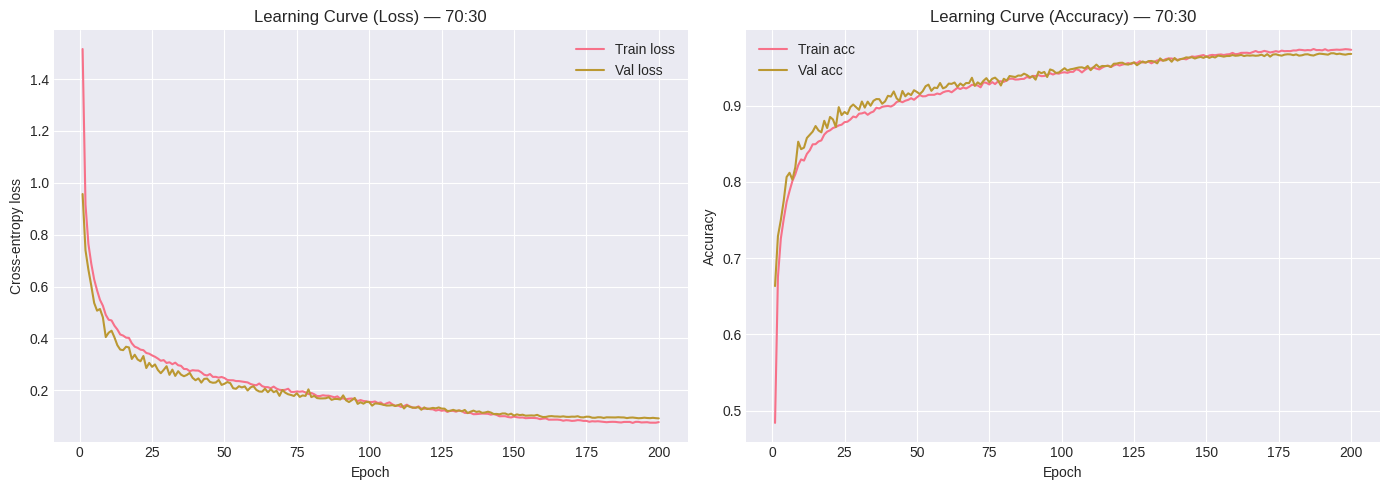

    Curves saved → curves_70_30.png


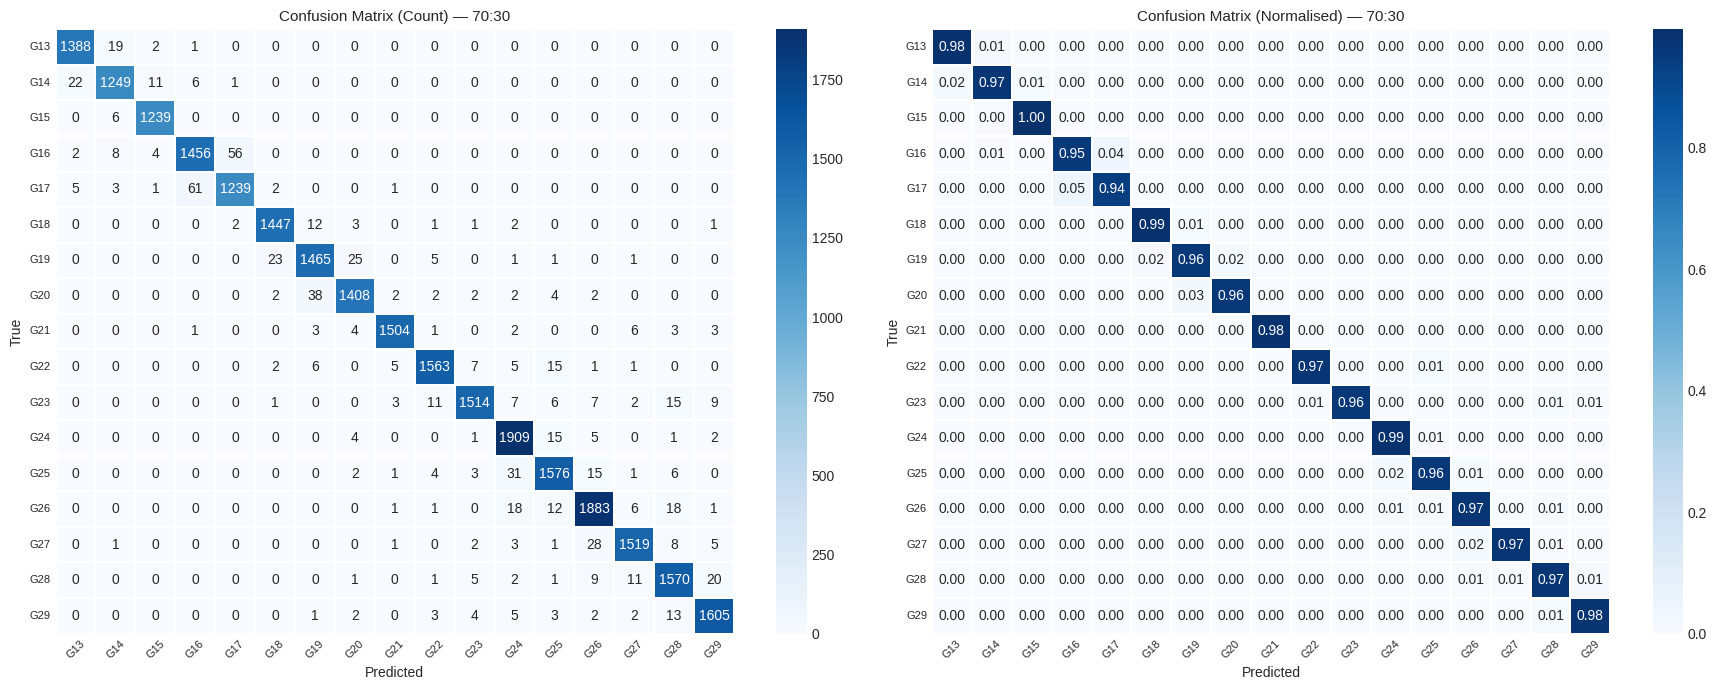

    CM saved → cm_70_30.png


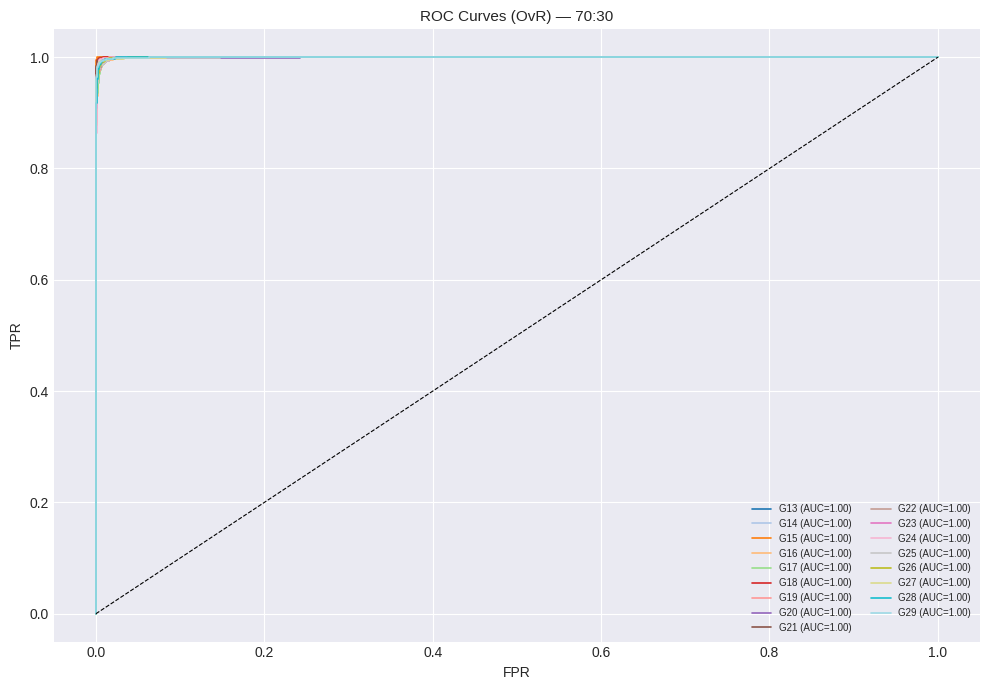

    ROC saved → roc_70_30.png

  Results  70:30
    Accuracy      : 0.9714
    Precision (W) : 0.9715
    Recall (W)    : 0.9714
    F1 (W)        : 0.9714
    ROC-AUC (W)   : 0.9997
    Train wall    : 1112.5 s
    Test wall     : 2.08 s
    GFLOPs/win    : -1.0000
    Model saved → tinymyo_70_30.pt

  Split  60:40  |  train=60%  test=40%
  Sizes  train=47,311  val=5,257  test=35,046
  TinyMyo params : 102,929
  GFLOPs/window  : -1.0000  (input 48×400)
  Epoch  10  train_loss=0.4826 train_acc=0.8262  val_loss=0.4048 val_acc=0.8585
  Epoch  20  train_loss=0.3729 train_acc=0.8646  val_loss=0.3191 val_acc=0.8828
  Epoch  30  train_loss=0.3101 train_acc=0.8862  val_loss=0.2725 val_acc=0.9047
  Epoch  40  train_loss=0.2792 train_acc=0.8974  val_loss=0.2450 val_acc=0.9091
  Epoch  50  train_loss=0.2469 train_acc=0.9091  val_loss=0.2210 val_acc=0.9203
  Epoch  60  train_loss=0.2268 train_acc=0.9175  val_loss=0.2160 val_acc=0.9188
  Epoch  70  train_loss=0.2076 train_acc=0.9228  val_loss=0.20

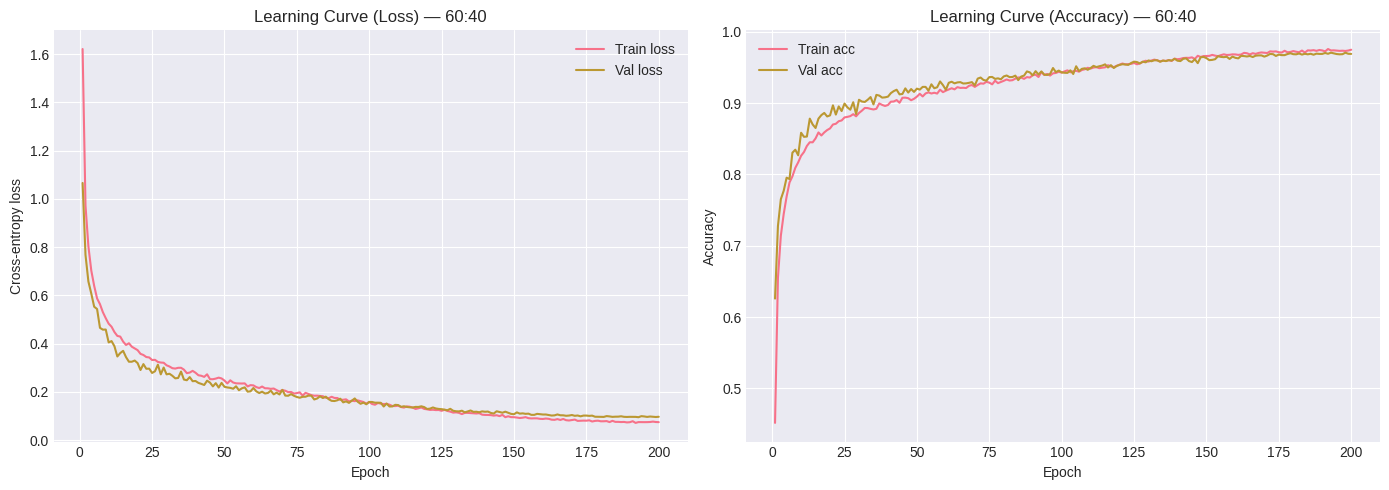

    Curves saved → curves_60_40.png


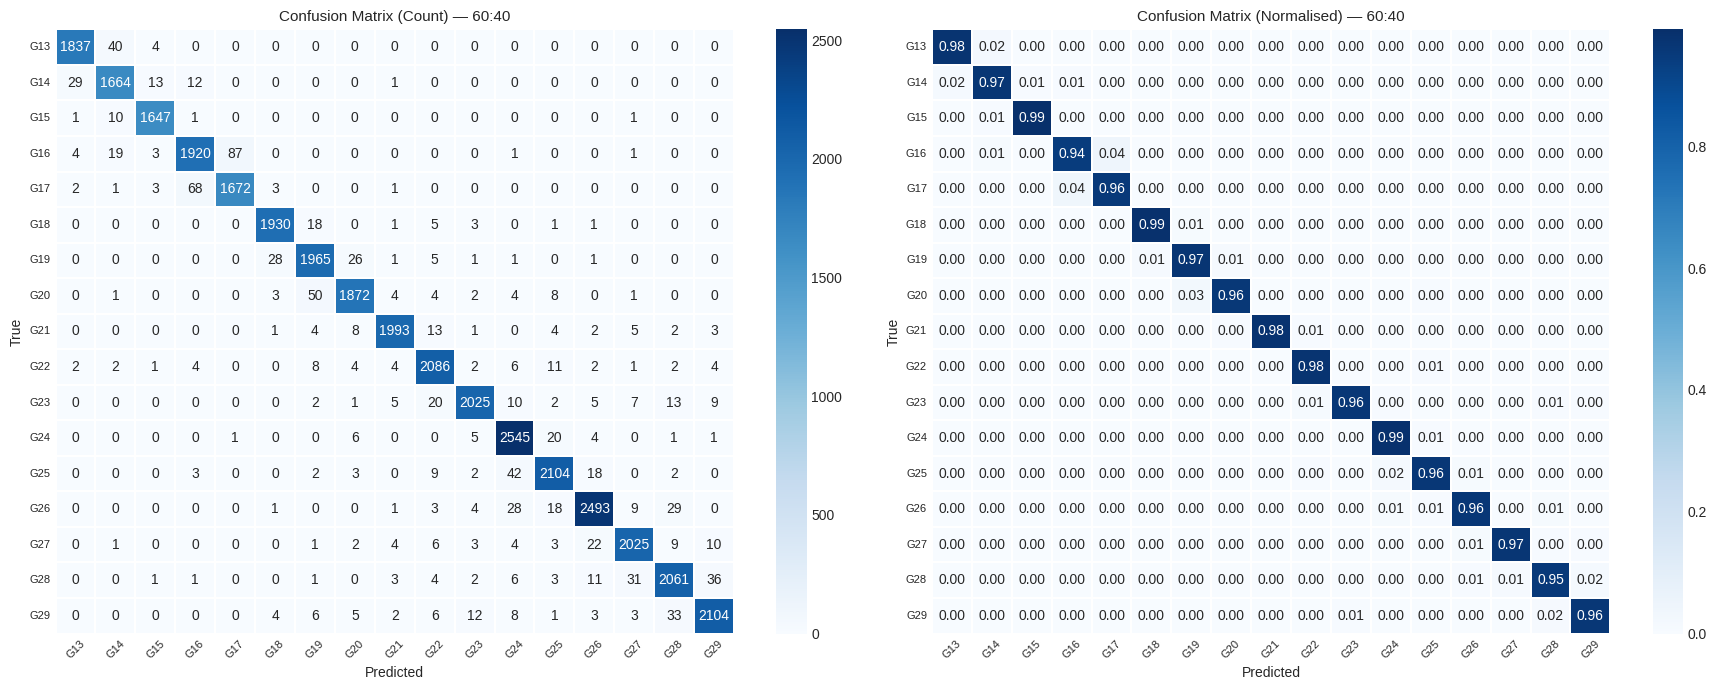

    CM saved → cm_60_40.png


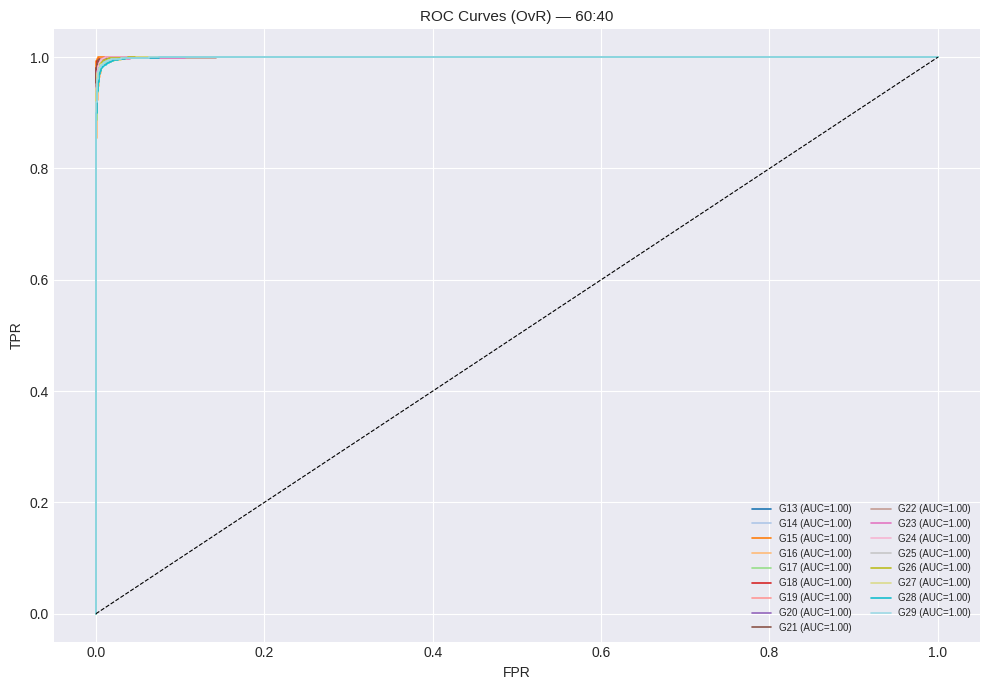

    ROC saved → roc_60_40.png

  Results  60:40
    Accuracy      : 0.9685
    Precision (W) : 0.9686
    Recall (W)    : 0.9685
    F1 (W)        : 0.9685
    ROC-AUC (W)   : 0.9996
    Train wall    : 914.1 s
    Test wall     : 2.54 s
    GFLOPs/win    : -1.0000
    Model saved → tinymyo_60_40.pt

  Split  50:50  |  train=50%  test=50%
  Sizes  train=39,426  val=4,381  test=43,807
  TinyMyo params : 102,929
  GFLOPs/window  : -1.0000  (input 48×400)
  Epoch  10  train_loss=0.5700 train_acc=0.7949  val_loss=0.5696 val_acc=0.7959
  Epoch  20  train_loss=0.4152 train_acc=0.8507  val_loss=0.4461 val_acc=0.8336
  Epoch  30  train_loss=0.4467 train_acc=0.8397  val_loss=0.3786 val_acc=0.8596
  Epoch  40  train_loss=0.4049 train_acc=0.8553  val_loss=0.4181 val_acc=0.8475
  Epoch  50  train_loss=0.3096 train_acc=0.8891  val_loss=0.2971 val_acc=0.8923
  Epoch  60  train_loss=0.2727 train_acc=0.9014  val_loss=0.2885 val_acc=0.8927
  Epoch  70  train_loss=0.2856 train_acc=0.8969  val_loss=0.293

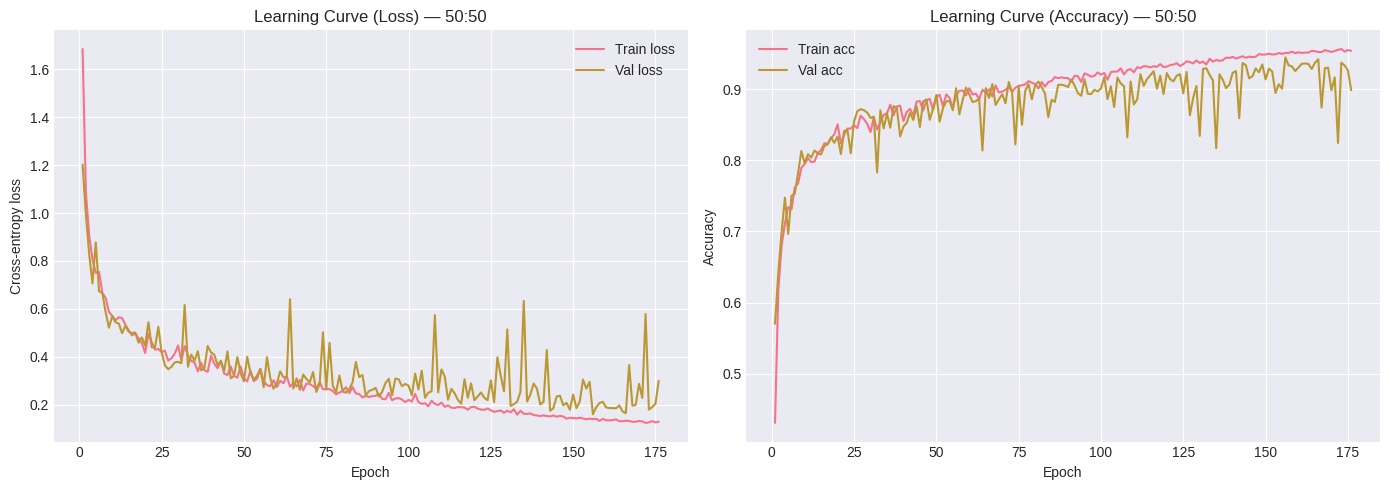

    Curves saved → curves_50_50.png


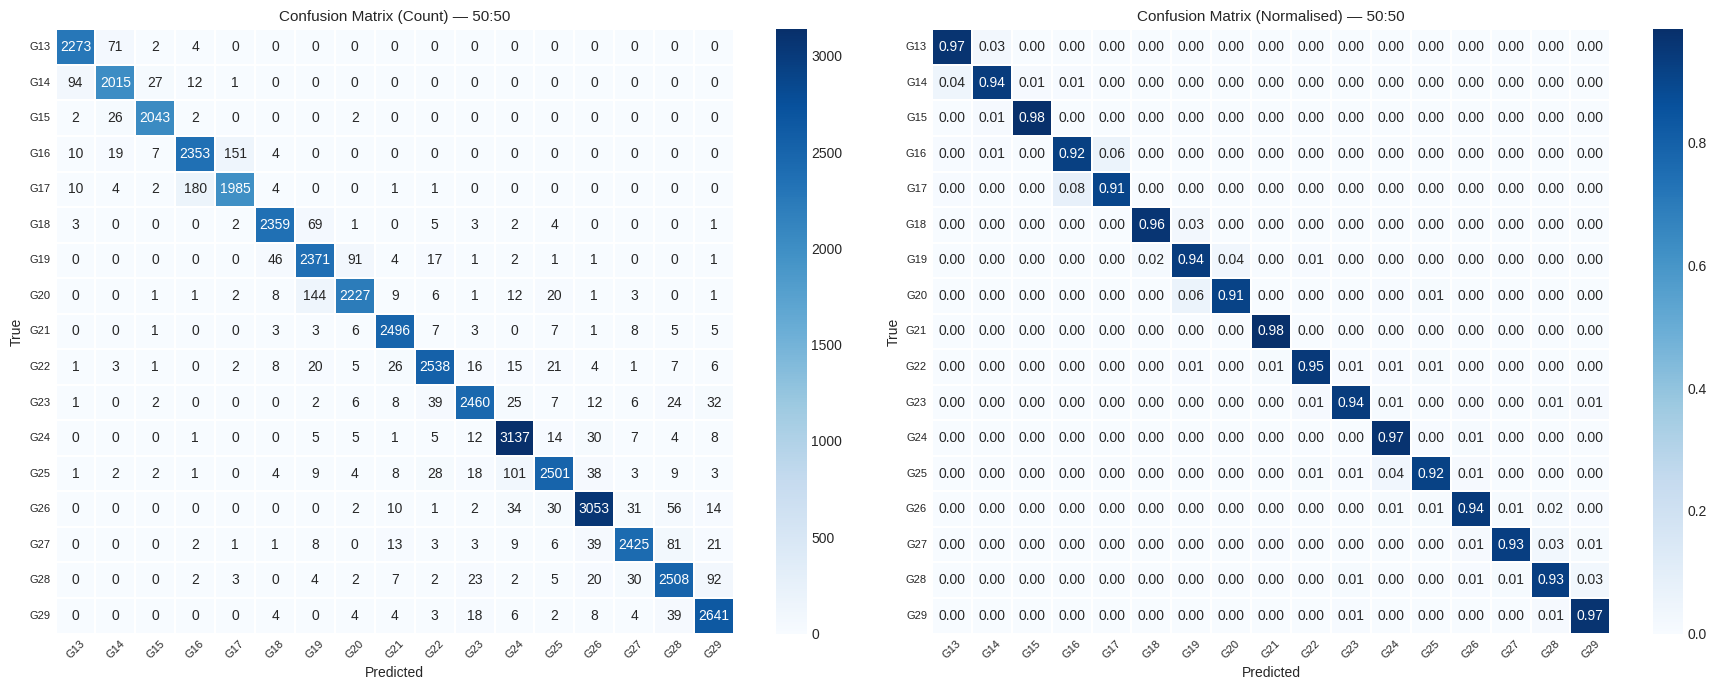

    CM saved → cm_50_50.png


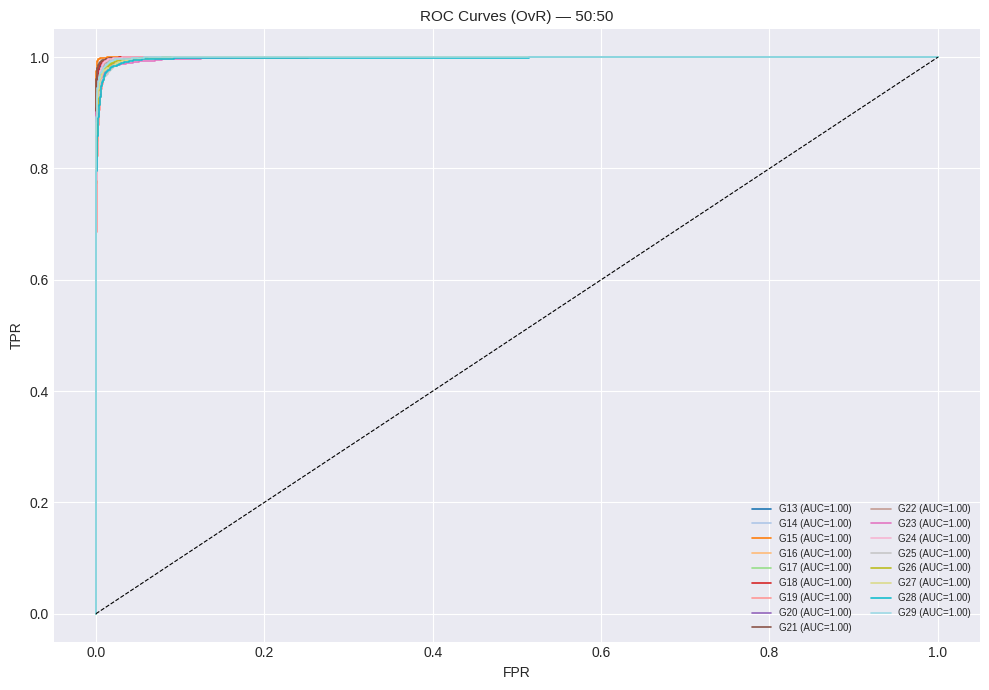

    ROC saved → roc_50_50.png

  Results  50:50
    Accuracy      : 0.9447
    Precision (W) : 0.9449
    Recall (W)    : 0.9447
    F1 (W)        : 0.9447
    ROC-AUC (W)   : 0.9990
    Train wall    : 679.5 s
    Test wall     : 3.18 s
    GFLOPs/win    : -1.0000
    Model saved → tinymyo_50_50.pt

  FAILURE MODE ANALYSIS

  Per-class mean accuracy (worst → best):
             G17  0.936  ████████████████████████████
             G16  0.941  ████████████████████████████
             G20  0.946  ████████████████████████████
             G25  0.947  ████████████████████████████
             G28  0.951  ████████████████████████████
             G23  0.955  ████████████████████████████
             G27  0.955  ████████████████████████████
             G19  0.956  ████████████████████████████
             G14  0.958  ████████████████████████████
             G26  0.960  ████████████████████████████
             G22  0.966  ████████████████████████████
             G29  0.969  ████████████

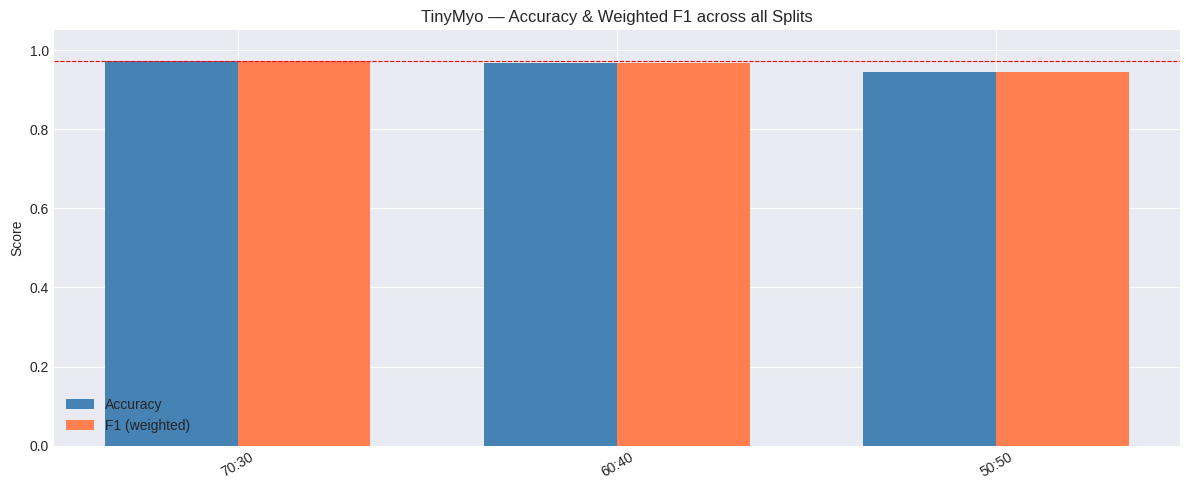

  Summary chart saved → summary_all_splits.png

  FINAL SUMMARY
split  train_size  test_size  accuracy  precision_w  recall_w     f1_w  roc_auc_w  train_wall_s  test_wall_s  gflops_per_window
70:30       55196      26285  0.971429     0.971472  0.971429 0.971421   0.999707   1112.505655     2.077921               -1.0
60:40       47311      35046  0.968527     0.968582  0.968527 0.968521   0.999606    914.073304     2.539186               -1.0
50:50       39426      43807  0.944712     0.944934  0.944712 0.944679   0.999012    679.537710     3.177660               -1.0

  Summary CSV → /kaggle/working/results_exB/summary_all_splits.csv
  Plots       → /kaggle/working/plots_exB
  Models      → /kaggle/working/ckpts_exB

 Best supervised baseline: split 70:30  (Weighted F1 = 0.9714)
  Use this as the reference for SSL experiments.



In [18]:
if __name__ == '__main__':
    main()